# Black and White Image Generation with a Probabilistic Model

In this notebook, we'll develop a probabilistic model that generates 3x3 black and white images. The probability of generating each image will be proportional to the number of black pixels in the image.

We will use the Categorical distribution from PyTorch to achieve this.

In [4]:
## Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

Generate All Possible 3x3 Images
First, we'll generate all possible 3x3 black and white images.

In [5]:
total_pixels = 9  # 3x3 image
all_images = [np.array([int(x) for x in format(i, '0' + str(total_pixels) + 'b')]).reshape(3, 3) 
              for i in range(2 ** total_pixels)]


### Calculate Probabilities
Now, we'll calculate probabilities that are proportional to the number of black pixels in each image.

In [8]:
probs = [np.sum(image) for image in all_images]
probs = np.array(probs) / np.sum(probs)

### Create the Categorical Distribution
We'll use PyTorch's Categorical distribution to sample images based on the calculated probabilities.



In [9]:
categorical_dist = dist.Categorical(torch.tensor(probs))


### Sample and Visualize Images
Finally, we'll draw five samples and visualize them.


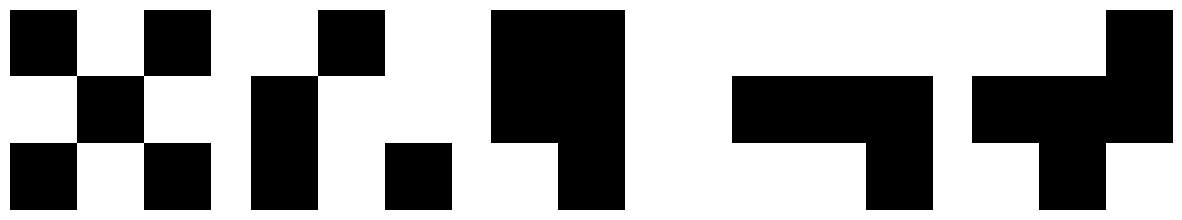

In [10]:
samples = [all_images[categorical_dist.sample().item()] for _ in range(5)]

# Visualization
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, sample in enumerate(samples):
    axes[i].imshow(sample, cmap='gray')
    axes[i].axis('off')
plt.show()


### Tasks performed until this point 
1. Imports the required libraries.
2. Generates all possible 3x3 black and white images.
3. Calculates probabilities proportional to the number of black pixels in each image.
4. Creates a Categorical distribution using these probabilities.
5. Draws five samples from this distribution and visualizes them.

# Learning the Data Generation Rule with MLP

We no longer know the data generation rule and want to learn it from 200 unique data points. We'll consider the probability of generating each training image as the label and train a Multilayer Perceptron (MLP) to develop a new probabilistic model.

In [11]:
## Import Required Libraries
import random
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

### Sample 200 Unique Images
Let's first sample 200 unique images from our original Categorical distribution.

In [13]:
unique_samples_index = torch.unique(dist.Categorical(torch.tensor(probs)).sample((512,)), sorted=True)[:200]
unique_probs = probs[unique_samples_index]
unique_samples = [all_images[i] for i in unique_samples_index]


### Prepare Data for Training


In [14]:
flattened_samples = torch.tensor([img.flatten() for img in unique_samples]).type(torch.FloatTensor)
labels = torch.tensor(unique_probs).type(torch.FloatTensor)

X_train, X_val, y_train, y_val = train_test_split(flattened_samples, labels, test_size=0.2, random_state=42)
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_222527/3730610889.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  flattened_samples = torch.tensor([img.flatten() for img in unique_samples]).type(torch.FloatTensor)


### Define and Train the MLP


In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size),
        )
    def forward(self, x):
        return self.layers(x)

input_size = 9  # 3x3 image
hidden_size = 64
output_size = 1
model = MLP(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


### Develop a New Probabilistic Model


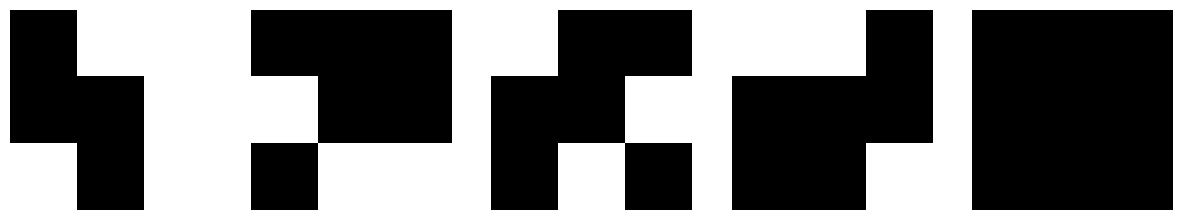

In [17]:
# Develop a New Probabilistic Model
with torch.no_grad():
    all_flattened_images = torch.tensor([img.flatten() for img in all_images]).type(torch.FloatTensor)
    predicted_probs = model(all_flattened_images).flatten()  # Flatten the tensor to one dimension
    normalized_predicted_probs = torch.nn.functional.softmax(predicted_probs, dim=0)  # No need for .numpy()

# Create new Categorical distribution with normalized predicted probabilities
new_categorical_dist = dist.Categorical(normalized_predicted_probs)

# Sample and visualize new images
new_samples = [all_images[new_categorical_dist.sample().item()] for _ in range(5)]

# Visualization
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, sample in enumerate(new_samples):
    axes[i].imshow(sample, cmap='gray')
    axes[i].axis('off')
plt.show()


# Learning the Data Generation Rule for 28x28 Images with MLP

This notebook aims to extend the previous approach to 28x28 dimensions. We'll draw 200 random samples, train an MLP, and discuss why this strategy does not scale well for higher dimensions.



In [18]:

## Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [20]:
#Initialize Parameters
width, height = 28, 28
total_pixels = width * height
input_size = total_pixels
hidden_size = 64
output_size = 1


### Draw 200 Random Samples
Here, we'll employ a categorical distribution to generate 200 random 28x28 images. 

In [23]:

image_size = (28, 28)

# Generate probabilities proportional to the number of black pixels
total = sum(range(1, (28*28) + 1))
probabilities = [i / total for i in range(28 * 28)]
probabilities = torch.tensor(probabilities)

categorical_dist = dist.Categorical(probabilities)


# Draw 5 samples from the distribution instead of 200
num_samples = 5
samples = []

for _ in range(num_samples):
    num_black_pixels = categorical_dist.sample()
    image = torch.zeros(*image_size)
    black_indices = torch.randperm(image_size[0] * image_size[1])[:num_black_pixels]
    image.view(-1)[black_indices] = 1
    samples.append(image)


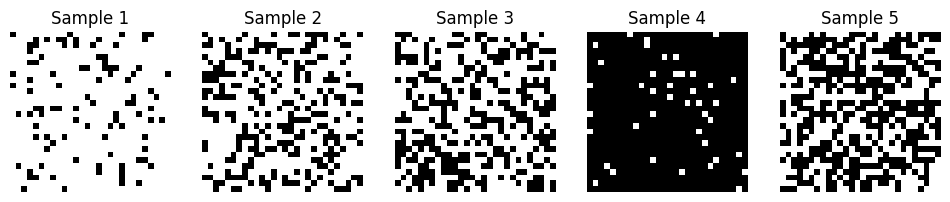

In [24]:
plt.figure(figsize=(12, 3))
for i, sample in enumerate(samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Sample {i + 1}')
    
plt.show()

### Define and Train the MLP


In [29]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size),
        )
    def forward(self, x):
        return self.layers(x)

model = MLP(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000


In [32]:

# Generate some mock data (replace this with your actual data)
N = 200  # Number of samples
X = torch.randn(N, 28*28)  # 28x28 flattened to 784
y = torch.randn(N, 1)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize MLP, Loss, and Optimizer
input_size = 28 * 28
hidden_size = 64
output_size = 1

model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1000
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    # if epoch % 100 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training complete.")

torch.Size([200, 28, 28])
torch.Size([200])
Training complete.


In [ ]:
# Validation loop
total_pixels = 28*28
all_images = [np.array([int(x) for x in format(i, '0' + str(total_pixels) + 'b')]).reshape(28, 28) 
              for i in range(2 ** total_pixels)]
print(all_images[0:10])
model.eval()
with torch.no_grad():
    mlp_samples = []
    all_probabilities = []
    num_pixels = []
    for image in all_images:
        all_probabilities.append(float(model(torch.FloatTensor(image).view(-1, input_size))))
        num_pixels.append(np.count_nonzero(image == 0))
        if np.count_nonzero(image == 0) == 0:
            print(float(model(torch.FloatTensor(image).view(-1, input_size))))
    sum_probabilities = {}
    count_occurrences = {}
    for num_pixel, probability in zip(num_pixels, all_probabilities):
        if num_pixel in sum_probabilities:
            sum_probabilities[num_pixel] += probability
            count_occurrences[num_pixel] += 1
        else:
            sum_probabilities[num_pixel] = probability
            count_occurrences[num_pixel] = 1

# Calculate the average probabilities for each unique value
average_probabilities = {num_pixel: sum_probabilities[num_pixel] / count_occurrences[num_pixel] for num_pixel in sum_probabilities}
print(average_probabilities)    


### Challenges in Scaling the MLP for High-Dimensional Generative Modeling

##### 1. Memory Limitations
Generating all possible $2^{28 \times 28}$ image combinations is computationally infeasible and kernel terminates due to out-of-memory errors.

##### 2. Model Complexity
The MLP architecture is too simplistic to capture the intricate, high-dimensional data distribution. The model fails to capture the underlying data distribution effectively.

##### 3. Inefficiency of Rejection Sampling
The model's predictions are not aligning well with the true data distribution. A 20-minute run of a rejection sampling algorithm failed to produce any samples that met the acceptance criteria.

These limitations highlight the challenges of using a rudimentary MLP and naive sampling methods for high-dimensional generative tasks.
